In [1]:

import argparse
import sys
import time
import numpy as np
from datasets.dataset import VocDataset, ImageInfo
from config import cfg
from utils import np_utils, eval_utils
from ssd import ssd_model
from utils.generator import TestGenerator
from utils.preprocess import EvalTransform
from typing import List

dataset = VocDataset(cfg.voc_path, class_mapping=cfg.class_mapping)
dataset.prepare()
print("len:{}".format(len(dataset.get_image_info_list())))
image_info_list=dataset.get_image_info_list()

# 加载模型
m = ssd_model(cfg.feature_fn, cfg.input_shape, cfg.num_classes, cfg.specs,
              stage='debug')


/Users/yizuotian/miniconda2/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yizuotian/miniconda2/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yizuotian/miniconda2/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yizuotian/miniconda2/envs/k

Parsing annotation files
len:5011
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [2]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [3]:
import cv2
def draw(image, boxes):
    im = image.copy().astype(np.uint8)
    for box in boxes.astype(np.int32):
        # print(box)
        y1, x1, y2, x2 = box
        
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255), 2)
    plt.imshow(im)
    plt.show()

## 原始图像

In [4]:
import numpy as np
transforms = EvalTransform(cfg.image_size)
size=len(image_info_list)


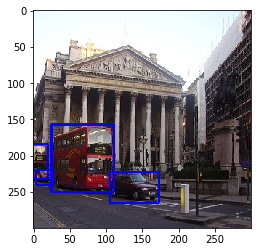

In [11]:
import matplotlib.pyplot as plt
image_info=image_info_list[np.random.choice(size)]
image = cv2.imread(image_info.image_path)[:, :, ::-1]
gt_boxes = image_info.boxes.copy()  # 不改变原来的
gt_class_ids = image_info.labels
# resize图像
image, gt_boxes, gt_class_ids = transforms(image, gt_boxes, gt_class_ids)
draw(image,gt_boxes)

# padding to fixed size
gt_boxes=np_utils.pad_to_fixed_size(gt_boxes, cfg.max_gt_num)
gt_class_ids=np_utils.pad_to_fixed_size(
                np.expand_dims(gt_class_ids, axis=1),
                cfg.max_gt_num)

## 匹配的anchors

In [12]:
cls_ids, anchors_tag,logits=m.predict((image[np.newaxis,:,:,:],
                               gt_boxes[np.newaxis,:,:],
                              gt_class_ids[np.newaxis,:,:]))

In [13]:
from utils.anchor import generate_anchors
anchors = generate_anchors(cfg.specs)
anchors_tag=anchors_tag[0]

In [14]:
pos=anchors[anchors_tag==1]
pos=np.clip(pos,0,cfg.image_size).astype(np.int32)
labels=cls_ids[0][anchors_tag==1]
pos,labels

(array([[144,  32, 223, 111],
        [160,  16, 239,  95],
        [160,  32, 239, 111],
        [160,  48, 239, 127],
        [176,  16, 255,  95],
        [176,  32, 255, 111],
        [202, 106, 262, 166],
        [226,  77, 269, 162],
        [230,  68, 265, 171],
        [218, 106, 278, 166],
        [226,  93, 269, 178],
        [230,  84, 265, 187],
        [218, 122, 278, 182],
        [226, 109, 269, 194],
        [230, 100, 265, 203],
        [142,   0, 247,  97],
        [157,   0, 232, 119],
        [142,  22, 247, 127],
        [120,  37, 269, 112],
        [157,   0, 232, 149],
        [132,  12, 257, 137],
        [172,  22, 277, 127],
        [150,  37, 299, 112]], dtype=int32),
 array([4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
        4], dtype=int32))

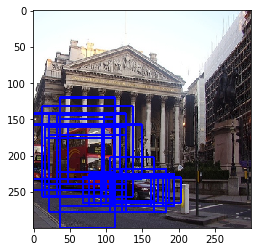

In [15]:
draw(image,pos)

In [16]:
np.unique(cls_ids[0][anchors_tag!=1])

array([0], dtype=int32)

In [22]:
np.max(logits[0])

1.9151331e-07